# Import

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from datetime import datetime
import shutil
import time
import sys
sys.path.append('../')

import ipywidgets as widgets
import pprint as pp
#from tqdm.notebook import tqdm
import matplotlib.gridspec as gridspec
from threading import Thread
import traceback
from functools import partial

import subprocess
from scipy import constants
from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment
from scipy import signal
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output
from ipywidgets import interact, widgets
from scipy.spatial import distance_matrix

os.chdir("/home/ilimnuc/plantProj/")
from BosonSDK import *


# MARK'S LIB
from flirpy.camera.boson import Boson
from lib.opencv_video_utils import videoPlayer

# ------ GLOBALS ------
import matplotlib as mpl 
# %matplotlib widget

# ------ VISIBLE CAMERA ------
from cameras.ids_ueye import uEye

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

if 'run_opt' not in locals():
    run_opt = {}
                
FONT = cv2.FONT_HERSHEY_SIMPLEX

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

# GLOBALS
EPS = np.finfo(np.float32).eps

def create_default_opt():
    run_opt =  {}
    return run_opt

if 'run_opt' not in locals():
    run_opt = create_default_opt()

CAMERA_FPS = 60

print('Import completed.')

Import completed.


# Project lib

In [2]:
from lib.image_processing import adjustGamma
from IPython.display import clear_output

import matplotlib.cm as cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from scipy import constants

# --------- MISC ----------        
def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def adc_to_temp(S):
    R1 = 635160
    R2 = 7340
    B = 1435+60
    F = 1
    O = 1.8248e4
    Tfpa = 273.18 + 31;
    radiance_housing = R2/(np.exp(B/Tfpa) - F) + O
    
    # Compute radiance only from scene
    radiance_scene = S - radiance_housing
    return B/np.log(R1/radiance_scene + F)

# --------- AUX ----------
def export_plot_video(filename,plot_func,
                      FPS,plot_size,N_frames,frame_step = 3):
    # create OpenCV video writer
    fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    video = cv2.VideoWriter(filename,
    fourcc,    
    FPS,
    (plot_size[0]*100, plot_size[1]*100))
    

    for i in range(0,N_frames,frame_step):
        fig    = plot_func(i)
        # put pixel buffer in numpy array
        canvas = FigureCanvas(fig)
        canvas.draw()
        mat = np.array(canvas.renderer._renderer)
        mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)

        video.write(mat)

    # close video writer
    cv2.destroyAllWindows()
    video.release()
    clear_output(wait=True)
    print("DONE")    
def plot(sig):
    plt.figure()
    plt.plot(sig)
    
def imshow(img):
    plt.figure()
    plt.imshow(img)
def draw_axis(img, mtx,dist,rvec,tvec,w=30):
    # unit is mm
    points = np.float32([[w, 0, 0], [0, w, 0], [0, 0, w], [0, 0, 0]]).reshape(-1, 3)
    axisPoints, _ = cv2.projectPoints(points,rvec, tvec, mtx, dist)
    axisPoints = axisPoints.squeeze().astype(int)
    print(axisPoints[3])
    img = cv2.line(img, axisPoints[3], axisPoints[0], (255,0,0), 3)
    img = cv2.line(img, axisPoints[3], axisPoints[1], (0,255,0), 3)
    img = cv2.line(img, axisPoints[3], axisPoints[2], (0,0,255), 3)
    return img

# --------- Diffusion model ----------
def compute_estimated_diffused_images_filt(u0,x,t):
    
    def gaussuian_filter(kernel_size, sigma=1, muu=0):

        x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                           np.linspace(-1, 1, kernel_size))
        dst = np.sqrt(x**2+y**2)

        # lower normal part of gaussian
        normal = 1/ (2*np.pi* sigma**2)

        # Calculating Gaussian filter
        gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2))) * normal
        gauss /= gauss.sum()
        return gauss
    
    F = x[0]
    L = x[1]
    u_vec = np.zeros((len(t),) + u0.shape) 
    
    for i in range(len(t)):
        sigma = np.sqrt(2*t[i]*F)
        if sigma==0:
            u_vec[i] = u0
        else:
            kernel = gaussuian_filter(21, sigma = sigma)
            u_vec[i] = cv2.filter2D(u0,-1,kernel) - L*(u0**4 - u_dc.mean()**4)
    return u_vec
def compute_estimated_diffused_images(u0,x,t):
    #D     = x[0]*1e-2
    T_amb = x[0]*1e2
    L2    = x[1]*1e-11
    
    def D(t):
        x0 = x[2]*1e-2
        x1 = x[3]*1e-2
        w =  x[5]
        sigmaD = 1.0 / (1.0 + np.exp(-(x[4] - t) / w))
        L_rad =  x0 + (x1 - x0)*(1 - sigmaD)
        return L_rad
    
    Q = lambda u:  -(u**4 - T_amb**4)*L2
    
    u = u0.astype(float)
    kernel = np.array([[0.25,0.5,0.25],[0.5,-3,0.5],[0.25,0.5,0.25]])
    #kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])
    
    u_vec  = np.zeros((len(t),) + u0.shape) 
    t_total= 0 
    t_int  = t.astype(int)
    t_mod  = t % 1
    
    for time_idx in range(len(t)):
        time_steps = t_int[time_idx] - t_int[time_idx-1] if time_idx>0 else t_int[time_idx]
        for i in range(time_steps):
            u += D(t_total)*cv2.filter2D(u,-1,kernel) + Q(u)
            t_total+=1
            
        if t_mod[time_idx]>0:
            u += t_mod[time_idx]*(D(t_total)*cv2.filter2D(u,-1,kernel)  + Q(u))
            t_total+=t_mod[time_idx]
            
        u = np.nan_to_num(u)    
        u_vec[time_idx] = u
    return u_vec


# -------- CAMERA -------- 
def thermal_cam_operation(frame,minmax=None):
    frame = frame.astype(np.float32)

    # Rescale to 8 bit
    if minmax is None:
        frame_min = frame.min()
        frame_max = frame.max()
    else:
        frame_min,frame_max = minmax
                
    # print(frame_min,frame_max)
    frame = 255*(frame - frame_min)/(frame_max-frame_min)    
    # Apply colourmap - try COLORMAP_JET if INFERNO doesn't work.
    # You can also try PLASMA or MAGMA
    frame = cv2.applyColorMap(frame.astype(np.uint8), cv2.COLORMAP_INFERNO)
    return frame, (frame_min,frame_max)
def combine_multiple_frames(frames):
    
    frame_show = frames[0]
    H,W        = frames[0].shape[0:2]

    try:
        for i in range(1,len(frames)):
            if frames[i].shape[0]==frame_show.shape[0]:
                frame_show   = np.concatenate((frame_show,frames[i]),axis=1)
            else:
                Hn,Wn        = frames[i].shape[0:2]

                frame_to_add = cv2.resize(frames[i],None,fx = H/Hn,fy = H/Hn)

                frame_show   = np.concatenate((frame_show,frame_to_add),axis=1)                        

    except Exception:
        traceback.print_exc()
        pass
    
    if len(frames)>1:
        cv2.line(frame_show,(frames[0].shape[1],0),
                            (frames[0].shape[1],frames[0].shape[0]), 
                            (0,0,255),1)
    return frame_show


## Cam Threads

In [3]:
class FrameThreadGeneral(Thread):
    def __init__(self, cam, copy=True):
        super(FrameThreadGeneral, self).__init__()
        self.cam = cam
        self.running = True
        self.frame = np.zeros((100,100,1),dtype='uint8')
        self.frame_counter = 0

    def run(self):
        while self.running:
            image,ret = self.cam.get_frame()
            if ret == True:
                self.frame = image
                self.frame_counter =  (self.frame_counter + 1) % 256

    def read(self):
        return self.frame, self.frame_counter
    def stop(self):
        self.cam.stop_video()
        self.running = False        
class CaptureThermal():
    # MAX_FRAMES = 1200
    def __init__(self, cam, cam_name, N_frames = None, VIS_H = 512, VIS_W = 640, vis_capture = False, is_color = False):
        # super(CaptureThread, self).__init__()
        self.cam         = cam
        self.cam_name    = cam_name
        self.vis_capture = vis_capture    
        self.N_frames    = N_frames #if N_frames is not None else self.MAX_FRAMES
        # In case we want to capture indefinitely (only possible if you're visualizing)
        # if N_frames is None and self.vis_capture:
        #     self.N_frames = None
        self.VIS_H       = VIS_H
        self.VIS_W       = VIS_W
        self.is_color = is_color
        self.data        = [] #np.zeros((N_frames,IMG_H,IMG_W),dtype=dtype)
        self.timestamps  = []# np.zeros((N_frames,4),dtype=int)
        self.succ_frames = [] # np.zeros((N_frames,),dtype=bool)
        self.use_minmax = False
        self.minmax = None

        self.stop_video = False
        self.record_video = False
        
    def run(self):
        self.frame_counter = 0
        self.cam.start_video()
        # self.succ_frames[:] = True
        if self.vis_capture:
            print('CaptureThread: starting visualization')
            cv2.namedWindow(self.cam_name)
            # self.fig = plt.figure()
            # self.ax = self.fig.add_subplot(111)
        if self.N_frames is not None:
            print('CaptureThread: recording {} frames'.format(self.N_frames))
            self.record_video = True
        while True:
            try:
                img_data,timestamp = self.cam.get_frame()
                if not self.vis_capture:
                    self.data.append(img_data)
                    self.timestamps.append(timestamp)
                    self.succ_frames.append(True)
                else:
                    self.show_capture(img_data.copy())
                    key = cv2.waitKey(1)
                    if key == 27:
                        self.stop_video = True
                    elif key == 32:
                        self.use_minmax = not self.use_minmax
                        if self.use_minmax:
                            print('CaptureThread: using minmax')
                        else:
                            print('CaptureThread: not using minmax')
                    elif key == ord('r'):
                        self.record_video = not self.record_video
                        if self.record_video:
                            print('CaptureThread: recording video')
                        else:
                            print('CaptureThread: stopped recording video')
                            self.stop_video = True
                    if self.record_video:
                        self.data.append(img_data)
                        self.timestamps.append(timestamp)
                        self.succ_frames.append(True)

            except:
                self.data.append(np.zeros((self.cam.IMG_H,self.cam.IMG_W),dtype='uint16'))
                self.timestamps.append(np.zeros((4,),dtype=int))
                self.succ_frames.append(False)
                print('CaptureThread: frame {} failed'.format(self.frame_counter))
            
            self.frame_counter += 1
            if self.N_frames is not None and self.frame_counter >= self.N_frames:
                self.stop_video = True
                self.record_video = False
            
            if self.stop_video:
                self.cam.stop_video()
                if self.vis_capture:
                    cv2.destroyWindow(self.cam_name)
                    # plt.close(self.fig)
                break

    
    def show_capture(self, frame):
        curr_frame_min, curr_frame_max = frame.min(), frame.max()
        if self.is_color:
            frame = cv2.cvtColor(frame, cv2.COLOR_BAYER_BG2BGR)
        else:
            frame, minmax = thermal_cam_operation(frame,self.minmax)
            if self.use_minmax and not(self.minmax is not None):
                self.minmax = minmax
                print('Minmax values set:', self.minmax)
            elif not self.use_minmax:
                self.minmax = None
        if frame.shape[0] != self.VIS_H or frame.shape[1] != self.VIS_W:
            frame = cv2.resize(frame,(self.VIS_W,self.VIS_H))
        cv2.putText(frame,self.cam_name,(30,30), FONT, 0.40,(255,255,255),2,cv2.LINE_AA)
        # Display curr_frame_min and curr_frame_max
        cv2.putText(frame,'Min: {}'.format(curr_frame_min),(30,50), FONT, 0.60,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(frame,'Max: {}'.format(curr_frame_max),(30,70), FONT, 0.60,(255,255,255),2,cv2.LINE_AA)
        cv2.imshow(self.cam_name,frame)    

    def read_data(self):
        return np.array(self.data).astype('uint16')

    def read_succ(self):
        return np.array(self.succ_frames)

    def read_times(self):
        return np.array(self.timestamps)

def capture(N_frames_to_record = None, vis_capture = False):
    imager = CaptureThermal(cam_t,'cam_t', N_frames_to_record, vis_capture=vis_capture, is_color=False)
    imager.run()
    frame_recording = [[]]
    frame_recording[0] = imager.read_data()
    time_stamps = [[]]
    time_stamps[0] = imager.read_times()
    return frame_recording, time_stamps

def normalize_img(img):
    img_n = img-img.min()
    img_n/= img_n.max()
    img_n = (img_n*255).astype('uint8')
    return img_n

## Boson Camera

In [4]:
class BosonCamera():
    def __init__(self,port):
        super(BosonCamera, self).__init__()
        self.cam = Boson(port=port)
        
    #def reconnect(self):
    #    self.cam = Boson()

    def get_frame(self):
        try:
            image = self.cam.grab()
            succ  = 1
        except:
            image=None
            succ = 0
        return image,succ
    
    def close(self):
        self.cam.close()
        
    def stop_video(self):
        pass
    
    def start_video(self):
        pass

# Visible Camera

In [5]:
vis_cam_obj = uEye()
vis_cam_obj.set_exposure(200)

Number of parameter sets: 1
Loaded parameter set 0
Camera initialized and has exposure range: [0.0549, 200.97245] ms
Exposure set to 199.99945000000002 ms


199.99945000000002

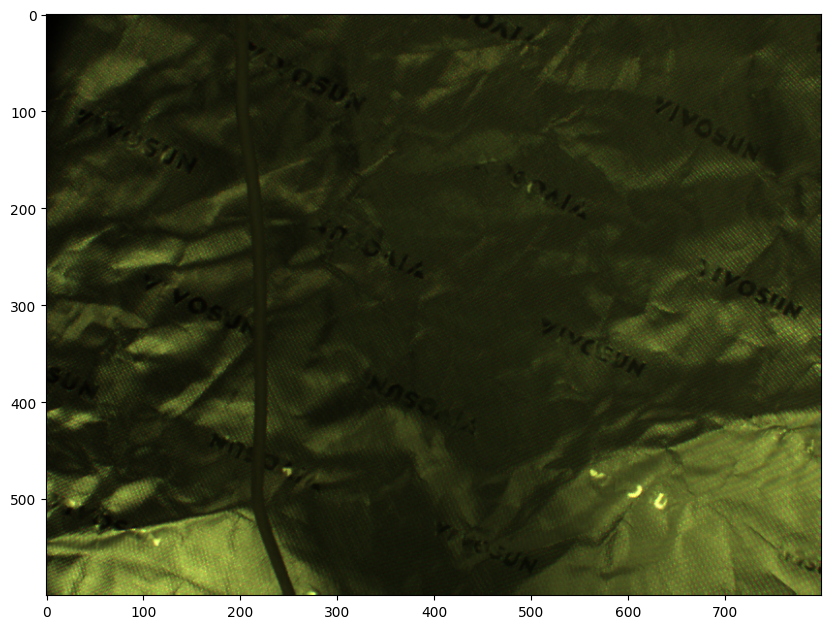

In [6]:
# Take reference image
vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()

vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)[..., ::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(vis_img_color)
plt.show()

# cv2.namedWindow('uEye', cv2.WINDOW_NORMAL)
# while True:
#     try:
#         key = cv2.waitKey(1)
#         if key == 13:
#             cv2.destroyAllWindows()
#             break
#         vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
#         vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)
        
#         cv2.imshow('uEye', vis_img_color)
#     except Exception:
#         traceback.print_exc()
#         print('Closing camera thread.')





In [7]:
del vis_cam_obj

# Macros

In [5]:
CAMERA = 'Boson'
RADIOMETRY_ENABLE = True
TSTABLE = True
TLINEAR = False

In [6]:

# Create a widget for each macro
camera_widget = widgets.Text(value=CAMERA, description='Camera:')
radiometry_widget = widgets.Checkbox(value=RADIOMETRY_ENABLE, description='Radiometry Enable:')
tlinear_widget = widgets.Checkbox(value=TLINEAR, description='Tlinear:')

# Display the widgets
display(camera_widget, radiometry_widget, tlinear_widget)


Text(value='Boson', description='Camera:')

Checkbox(value=True, description='Radiometry Enable:')

Checkbox(value=False, description='Tlinear:')

In [7]:
CAMERA = camera_widget.value
RADIOMETRY_ENABLE = radiometry_widget.value
TLINEAR = tlinear_widget.value

# Connect thermal camera

In [8]:
cam_t = BosonCamera(port='/dev/ttyACM1')
myCam = CamAPI.pyClient(manualport="/dev/ttyACM1")
cams  = [cam_t]

IMG_H, IMG_W = 512,640  
CAMERA_FPS   = 60

C serial FSLP load
Serial port open


## Apply Settings

In [9]:
if CAMERA == 'Boson' and RADIOMETRY_ENABLE:
    myCam.radiometrySetTempStableEnable(FLR_ENABLE_E.FLR_ENABLE)
    if TLINEAR:
        myCam.TLinearSetControl(FLR_ENABLE_E.FLR_ENABLE)
    else:
        myCam.TLinearSetControl(FLR_ENABLE_E.FLR_DISABLE)

## PREVIEW

In [10]:
def preview_system_cameras(cams,funcs,resize_factor = 1.5, is_color=False, gamma_val=2, use_grid = 0, camera_names=['cam t','cam 1','cam 2']): 
    try:
        threads = []
        for cam in cams:
            cam.start_video()
            
            thread = FrameThreadGeneral(cam)
            thread.start()
            threads.append(thread)

        cv2.namedWindow("frame")  
        is_first=1
        use_minmax = None
        while(True):
            frames = []
            for idx,thread in enumerate(threads):
                
                frame,thread_counter = thread.read()
                curr_frame_min, curr_frame_max = frame.min(), frame.max()
                if is_color:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BAYER_BG2BGR)
                if funcs[idx] is not None:
                    frame, minmax = funcs[idx](frame,use_minmax)
                if resize_factor!=1:
                    frame = cv2.resize(frame,None,fx = resize_factor, fy = resize_factor)
                    
                cv2.putText(frame,camera_names[idx],(30,30), FONT, 0.40,(255,255,255),2,cv2.LINE_AA)
                # Display curr_frame_min and curr_frame_max
                cv2.putText(frame,'Min: {}'.format(curr_frame_min),(30,50), FONT, 0.60,(255,255,255),2,cv2.LINE_AA)
                cv2.putText(frame,'Max: {}'.format(curr_frame_max),(30,70), FONT, 0.60,(255,255,255),2,cv2.LINE_AA)    
                frames.append(frame)

            frame_show = combine_multiple_frames(frames)
            
            # post-process
            if gamma_val != 1: 
                frame_show = adjustGamma(frame_show,gamma=gamma_val)
                cv2.putText(frame_show,'g={:.1f}'.format(gamma_val),
                        (frame_show.shape[1]-150,20), FONT, 0.75,(255,255,255),2,cv2.LINE_AA)

            cv2.imshow("frame",frame_show)

            key = cv2.waitKey(1) 
            if key==13:
                break
            elif key==32: #space
                use_minmax=minmax if use_minmax is None else None
            elif key==40:
                gamma_val-= 0.1
            elif key==41:
                gamma_val+= 0.1
                
    except Exception:
        traceback.print_exc()
        print('Closing camera thread.') 

    # cleanup
    cv2.destroyAllWindows()
    for thread in threads:
        thread.stop()
        thread.join()
    for cam in cams:        
        cam.stop_video()
        
func_list = [thermal_cam_operation]
# func_list = [None]
preview_system_cameras(cams,func_list,resize_factor=1,use_grid=1,gamma_val=1)

/tmp/ipykernel_225445/160358640.py:152: RuntimeWarning: invalid value encountered in divide
  frame = 255*(frame - frame_min)/(frame_max-frame_min)


## Capture Video

In [ ]:
frame_recording = []
time_stamps = []
myCam.bosonRunFFC()

In [ ]:
# N Frames to record (can be None)
N_frames_to_record = None
# N_frames_to_record = 10
# If N_frames is None then set this to True
# Cannot have vis right now.
vis_capture = True

tmp_frames, tmp_timestamps = capture(N_frames_to_record, vis_capture=vis_capture)
frame_recording.append(tmp_frames)
time_stamps.append(tmp_timestamps)

In [ ]:
print(len(frame_recording))
for recording in frame_recording:
    print(recording[0].shape)

In [ ]:
# Remove frame_recording if the list is empty for any element
frame_recording = [recording for recording in frame_recording if len(recording[0])>0]
time_stamps = [recording for recording in time_stamps if len(recording)>0]

In [ ]:
frame_recording = np.concatenate(frame_recording,axis=1)
time_stamps = np.concatenate(time_stamps,axis=1)

In [ ]:
print(frame_recording[0].shape)

In [ ]:
print(frame_recording.min(), frame_recording.max())

In [ ]:
# frame_recording = frame_recording[0, :3000]
# time_stamps = time_stamps[0, :3000]
# print(frame_recording.shape, time_stamps.shape)

## Show recording

In [ ]:
from lib.opencv_video_utils import videoPlayer

class videoPlayerRecording(videoPlayer):
    def __init__(self,frame_func,N_frames,resize_factor=None):
        videoPlayer.__init__(self,frame_func,N_frames,resize_factor=resize_factor)
        self.gamma          = 1
        
    def additional_loop_control(self,key):
        if key==ord('a'):
            self.is_draw_ROI = not self.is_draw_ROI    
        if key==ord('1'): #numpad 1
            self.apply_rotation = not self.apply_rotation
        return 0            
                
    def get_frame_show(self):
        return self.frame_func(self.data_counter)
    
    def correct_gamma_show(self, img):
        if self.gamma!=1:
            img = adjustGamma(img,self.gamma)
            cv2.putText(img,'g={:.1f}'.format(self.gamma),(img.shape[1]-150,20), FONT, 0.75,(255,255,255),2,cv2.LINE_AA)
        return img
        
def get_frameshow(data_counter):
    
    frames = []
    for i in range(len(frame_recording)):
        frames.append(frame_recording[i][data_counter].copy())
        
    for i in range(len(frames)):
        frames[i],minmax = thermal_cam_operation(frames[i],minmax=None)

    frame_show = combine_multiple_frames(frames)
    return frame_show

N_frames           = frame_recording[0].shape[0]
resize_factor      = 1
get_frame_func     = get_frameshow   

video_player       = videoPlayerRecording(get_frame_func,N_frames,resize_factor=resize_factor)
# video_player.set_frame_recordings(frame_recording)
# video_player.set_time_stamps(time_stamps)


In [ ]:
video_player.play_video(move_window=0,show_frame_number=1)

## Save video

In [ ]:
# save_dir_videos = '../DATA/obj_study_videos/'
# os.makedirs(save_dir_videos,exist_ok=True)
# # Save video with filename yyyy-mm-dd_hh-mm-ss.avi
# filename_vid = save_dir_videos+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'.avi'
# video_player.export_video(filename_vid,FPS=60)

# save_dir_raw = '../DATA/obj_study_raw/'
# os.makedirs(save_dir_raw,exist_ok=True)
# # Save video with filename yyyy-mm-dd_hh-mm-ss.avi
# filename_raw = save_dir_raw+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")+'.pkl'
# video_player.export_raw_as_pkl(filename_raw, frame_recording, time_stamps)

save_dir_raw = './DATA/obj_study_raw/'
os.makedirs(save_dir_raw,exist_ok=True)
# Save video with filename yyyy-mm-dd_hh-mm-ss.avi
# obj_name = 'duck'
# obj_name = 'tortoise'
# obj_name = 'glass_bottle-v2'
# obj_name = 'plate_1_4-v2'
# obj_name = "duck_cup_noheating"
# obj_name = 'soldering_iron-220-v2deg'
# obj_name = 'bb-50deg-nonradcam'
# obj_name = 'cup-painted-hotwater-v3'
# obj_name = 'soda_can-v43-1-right-incan'
# obj_name = 'ceramic-avg-hotwater'
# obj_name = 'cup-painted-avg-gridle'
# obj_name = 'wineglass-painted-hori-hotwater-v2'
# obj_name = 'wineglass-painted-incandescent-v1'
# obj_name = 'cup-painted-heatgun-v2'
# obj_name = 'cup-soldering-rod-v1'
# obj_name = 'cup-hotwater-hori-v2'

# obj_name = 'vase-cu-incandescent-v1'
# obj_name = 'cone-big-cu-v1'
# obj_name = 'cone-small-cu-v1'
# obj_name = 'cylinder-cu-v1'

# obj_name = 'polystyrene-matte-right-laser'
# obj_name = "polystyrene-flat-right-laser-wheating"
# obj_name = "cu-sheet-flat-front-laser-wheating"
# obj_name = "plastic-bottle-v3-v87-315deg-1-incan-bottomright"
# obj_name = "plastic-bottle-v9-4-front-slant-left"
# obj_name = "cu-sheet-vshape-v1-incandescent-wheating"
# obj_name = "plastic-cup-v2-incandescent-back"
# obj_name = "cup-220deg-v27-1-right"

# obj_name = "chrome-ball-right"
# obj_name = "plastic-bottle-v5-incan-30deg-v76-1-right"
# obj_name = 'ricup-v29-1-right'
# obj_name = "scurve-v30-1-right"
# obj_name = "bear-bw-v68-incan-1-bottomright"
# obj_name = "bear-v89-d3-1-incan-bottomright"
# obj_name = "sphere-v69-incan-1-bottomright"
# obj_name = "heart-v33-1-right"
# obj_name = 'plane-v41-1-right'
# obj_name = "cup-planes-v45-1-incan-right"
# obj_name = "bunny-black-v82-incan-1-right"
# obj_name = "printed_cone-v78-incan-1-bottomright"
# obj_name = "alsheet-lightbulb-t2"
obj_name = "milly-nc-rough-tilted-v2"

obj_name += f'-rad{int(RADIOMETRY_ENABLE)}-tlin{int(TLINEAR)}'
filename_raw = os.path.join(save_dir_raw, obj_name + datetime.now().strftime("-%Y-%m-%d_%H-%M-%S")+'.npz')
video_player.export_raw_as_pkl(filename_raw, frame_recording, time_stamps, vis_img=vis_img_color)

# Open the folder with the data
# os.system('nautilus ../DATA/diffusion_study/')

In [ ]:
cam_t.close()

# View Visible Video

In [ ]:
vis_cam_obj = uEye()
vis_cam_obj.set_exposure(200)

In [6]:
cv2.namedWindow('uEye', cv2.WINDOW_NORMAL)
while True:
    try:
        key = cv2.waitKey(1)
        if key == 13:
            cv2.destroyAllWindows()
            break
        vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
        vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)
        
        cv2.imshow('uEye', vis_img_color)
    except Exception:
        traceback.print_exc()
        print('Closing camera thread.')


# Save Visible Images

In [ ]:
print(vis_img.shape)

vis_img, vis_tstamp = vis_cam_obj.getNextImage(), time.time()
vis_img_color = np.floor(cv2.cvtColor(vis_img, cv2.COLOR_BayerRGGB2BGR) / 16).astype(np.uint8)

# --------- Save Visible Image ---------
save_dir_visible = './DATA/obj_study_raw/'
# exp_dir = "plastic-bottle-v3-v87"
exp_dir = "bear-v89"

os.makedirs(os.path.join(save_dir_visible, exp_dir), exist_ok=True)

# visible_img_name = "plastic-bottle-v3-v83-270deg"
# visible_img_name = "bunny-black-v82-incan-1-right"
# obj_name = "printed_cone-v78-incan-1-bottomright"

vis_img_fname = os.path.join(save_dir_visible, exp_dir, datetime.now().strftime("-%Y-%m-%d_%H-%M-%S")+'.png')
cv2.imwrite(vis_img_fname, vis_img_color)

plt.clf()
plt.imshow(vis_img_color[:,:,::-1])
plt.show()